In [23]:
import torch
import torch.nn as nn

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [31]:
import subprocess
from transformers import AutoModel, pipeline, Trainer, AutoTokenizer
import json
from datasets import Dataset, load_dataset, concatenate_datasets
import evaluate
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Perceptron
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

In [3]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/graphcodebert-base")
model = AutoModel.from_pretrained("microsoft/graphcodebert-base")

Some weights of RobertaModel were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
sampling_strategy = 1.0
rsmpl = RandomUnderSampler(sampling_strategy=sampling_strategy)

In [20]:

from tree_sitter import Language, Parser


CPP_LANGUAGE = Language('build/my-languages.so', 'cpp')

parser = Parser()
parser.set_language(CPP_LANGUAGE)

In [19]:
def get_index_code_dict(emb_ds):
    res_dict = {}
    
    for el in emb_ds:
        res_dict[el["index"]] = el["embedding"]
        
    return res_dict
    

In [18]:
#эмбеддинги для батча
def get_embeddings(inputs, model):
    with torch.no_grad():
        embeddings = model(**inputs).last_hidden_state.mean(dim=1)
    return embeddings

In [17]:
def get_pairs_ds(emb_ds):
    id = 0
    print(len(emb_ds))
    id_1 = []
    id_2 = []
    is_same = []
    same_class = []
    for i in range(len(emb_ds)-1):
        id += 1
        if id % 100 == 0 or id == 10:
            print(id)
        for j in range(i+1, len(emb_ds)):
            id_1.append(i)
            id_2.append(j)
            are_same = emb_ds[i]["label"] == emb_ds[j]["label"]
            is_same.append(int(are_same))
            if are_same:
                same_class.append(emb_ds[i]["label"])
            else:
                same_class.append(-100)

    dataset = Dataset.from_dict({ "id_1":id_1,"id_2": id_2,
                                    "is_same": is_same, "same_class": same_class})
    return dataset

In [43]:
def get_similarities_ds(emb_ds, resampled_ds):
    X = []
    y = []
    for el in resampled_ds:
        conc_tensor = torch.cat([
            torch.Tensor(emb_ds[el["id_1"]]["embeddings"]),
            torch.Tensor(emb_ds[el["id_2"]]["embeddings"]),
            torch.Tensor(pairwise_distances(emb_ds[el["id_1"]]["embeddings"],emb_ds[el["id_2"]]["embeddings"],
                                                   metric='cosine'))
        ], dim=1)
        X.append(conc_tensor.view(-1))
        y.append(el["is_same"])
    X_train, X_t, y_train, y_t = train_test_split(X, y, test_size=0.3, stratify=y, random_state=49)
    
    X_eval, X_test, y_eval, y_test = train_test_split(X_t, y_t, test_size=0.7, random_state=64)
    return X_train, X_eval, X_test, y_train, y_eval, y_test
        

In [15]:
def get_accuracy(emb_dataset):
    index_1 = []
    index_2 = []
    code_1 = []
    code_2 = []
    is_clones = []
    similarities = []
    for i in range(len(emb_dataset) - 1):
        i_label = emb_dataset[i]["label"]
        i_embeddings = torch.Tensor(emb_dataset[i]["embedding"][0]).reshape([1, -1])
        
        if i % 10 == 0:
            print(i)
            
        for j in range(i+1, len(emb_dataset)):
            j_label = emb_dataset[j]["label"]
            j_embeddings = torch.Tensor(emb_dataset[j]["embedding"][0]).reshape([1, -1])
            
            similarity = pairwise_distances(i_embeddings,j_embeddings,
                                                   metric='fgh')
            
            index_1.append(emb_dataset[i]["index"])
            index_2.append(emb_dataset[j]["index"])
            code_1.append(emb_dataset[i]["res_code"])
            code_2.append(emb_dataset[j]["res_code"])
            is_clones.append(int(emb_dataset[i]["label"] == emb_dataset[j]["label"]))
            similarities.append(similarity)
            
    acc_dataset = Dataset.from_dict({ "index_1":index_1,"index_2": index_2, "is_clones": is_clones,
                                "similarities": similarities})
    return acc_dataset
            
    
    

SEXP+CODE

In [14]:
def get_tokenized_dataset_sexp_code(datafile, model):
    index = []
    label = []
    code = []
    code_1 = []
    code_2 = []
    bin_labels = []

    input_ids_1 = []
    input_ids_2 = []
    att_mask_1 = []
    att_mask_2 = []
    embeddings = []


    cnt = 0
    with open(datafile) as file:
            for line in file.readlines():
                cnt += 1   
                if cnt%100==0:
                    print(cnt)
                
                json_line = json.loads(line)
                index.append(int(json_line["index"]))
                label.append(int(json_line["label"]) - 1)
                clear_code = json_line["code"].replace("\r", "").replace("\n","").replace("\t","")
                
                tree = parser.parse(bytes(clear_code, 'utf8'))
                sexp = str(tree.root_node.sexp())
                result = clear_code + sexp
                code.append(result)
                embeddings.append(get_embeddings(tokenizer(result, max_length = 512, truncation=True, pad_to_max_length=True,  return_tensors='pt'), model))
                

    dataset = Dataset.from_dict({ "res_code":code,"index": index, 
                                 "embeddings": embeddings,
                                "label": label})
    return dataset

In [19]:
rsm_test_sexp_code = get_tokenized_dataset_sexp_code("rsm_test.jsonl", model)
rsm_test_sexp_code.to_json("rsm_test_sexp_code.jsonl")

100
200
300
400
500
600
700
800
900
1000
1100
1200


Creating json from Arrow format: 100%|██████████| 2/2 [00:00<00:00,  8.85ba/s]


1200
10
100
200
300
400
500
600
700
800
900
1000
1100


Creating json from Arrow format: 100%|██████████| 720/720 [00:00<00:00, 956.09ba/s]


26006310

In [24]:
rsm_test_sexp_code = load_dataset("json", data_files="rsm_test_sexp_code.jsonl")["train"]

In [34]:
rsm_test_sexp_code_pairs = get_pairs_ds(rsm_test_sexp_code)
rsm_test_sexp_code_pairs.to_json("rsm_test_sexp_code_pairs_1.jsonl")

1200
10
100
200
300
400
500
600
700
800
900
1000
1100


Creating json from Arrow format: 100%|██████████| 720/720 [00:00<00:00, 759.04ba/s]


38846610

In [25]:
rsm_test_sexp_code_pairs = load_dataset("json", data_files="rsm_test_sexp_code_pairs_1.jsonl")["train"]
rsm_test_sexp_code_pairs

Generating train split: 118800 examples [00:00, 2084501.11 examples/s]


Dataset({
    features: ['id_1', 'id_2', 'same_class', '__index_level_0__', 'is_same'],
    num_rows: 118800
})

In [26]:
rsm_test_sexp_code = load_dataset("json", data_files="rsm_test_sexp_code.jsonl")["train"]
rsm_test_sexp_code

Dataset({
    features: ['res_code', 'index', 'embeddings', 'label'],
    num_rows: 1200
})

In [35]:
X = pd.DataFrame({"id_1": rsm_test_sexp_code_pairs["id_1"], "id_2": rsm_test_sexp_code_pairs["id_2"], "same_class": rsm_test_sexp_code_pairs["same_class"]})

y = rsm_test_sexp_code_pairs["is_same"]

X_resampled, y_resampled = rsmpl.fit_resample(X, y)

rsm_test_sexp_code_pairs = Dataset.from_pandas(X_resampled)

rsm_test_sexp_code_pairs = rsm_test_sexp_code_pairs.add_column("is_same", y_resampled)

rsm_test_sexp_code_pairs.to_json("rsm_test_sexp_code_pairs_1.jsonl")

Creating json from Arrow format: 100%|██████████| 119/119 [00:00<00:00, 613.40ba/s]


9516323

In [15]:
len(rsm_test_sexp_code_pairs.filter(lambda el: el["is_same"] == 1)) ==  len(rsm_test_sexp_code_pairs.filter(lambda el: el["is_same"] == 0))
print(len(rsm_test_sexp_code_pairs))
print(len(rsm_test_sexp_code_pairs.filter(lambda el: el["is_same"] == 1)))

118800
59400


In [44]:
X_train, X_eval, X_test, y_train, y_eval, y_test = get_similarities_ds(rsm_test_sexp_code, rsm_test_sexp_code_pairs)

In [29]:
from sklearn.metrics import f1_score

Epoch: 1 Validation Accuracy: 0.7621586232697344
Epoch: 2 Validation Accuracy: 0.7774971941638609
Epoch: 3 Validation Accuracy: 0.7843247287691733
Epoch: 4 Validation Accuracy: 0.6872427983539094
Epoch: 5 Validation Accuracy: 0.7692667414889637
Epoch: 6 Validation Accuracy: 0.808641975308642
Epoch: 7 Validation Accuracy: 0.771324354657688
Epoch: 8 Validation Accuracy: 0.716142910587355
Epoch: 9 Validation Accuracy: 0.8035914702581369
Epoch: 10 Validation Accuracy: 0.7885334829779275
Epoch: 11 Validation Accuracy: 0.8247287691732136
Epoch: 12 Validation Accuracy: 0.8236999625888515
Epoch: 13 Validation Accuracy: 0.8225776281331837
Epoch: 14 Validation Accuracy: 0.8264122708567153
Epoch: 15 Validation Accuracy: 0.813973063973064
Epoch: 16 Validation Accuracy: 0.8131313131313131
Early stopping triggered at epoch 16


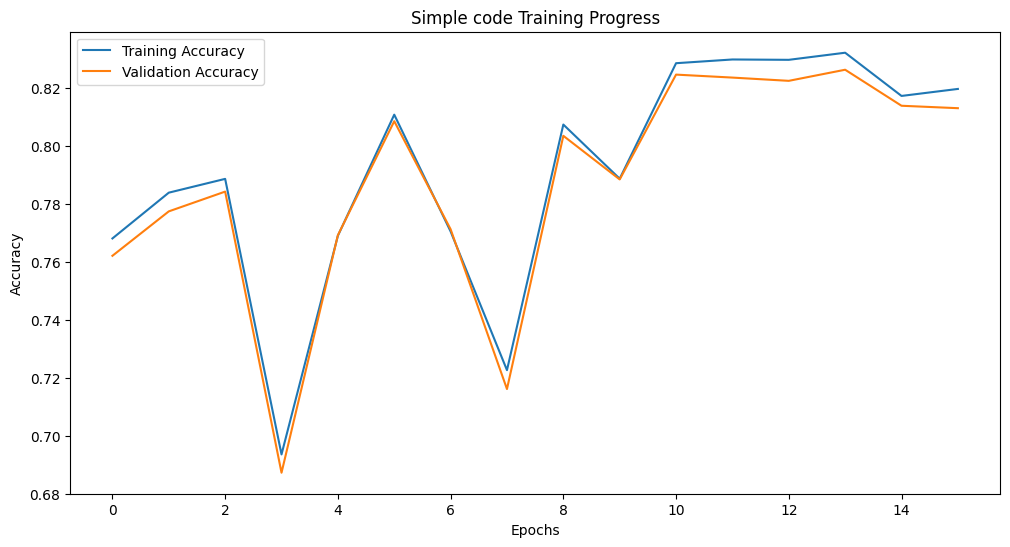

Accuracy: 0.8126503126503126
f1_score: 0.8392488650433347
s_выражения


Creating json from Arrow format: 100%|██████████| 25/25 [00:00<00:00, 862.10ba/s]


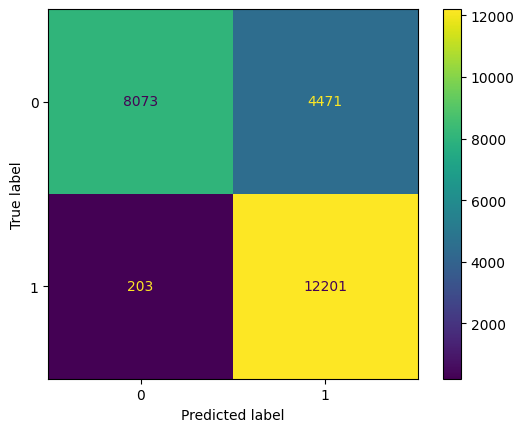

In [45]:
#классификационная голова с логированием

perceptron = Perceptron(tol=None, max_iter=1)

best_accuracy = 0
tol = 0.01
no_improvement = 0
max_no_improvement = 5

train_acc = []
val_acc = []

for epoch in range(1000):
    perceptron.partial_fit(X_train, y_train, classes=np.unique(y_train))
    
    y_pred_eval = perceptron.predict(X_eval)
    accuracy_eval = accuracy_score(y_eval, y_pred_eval)
    
    y_pred_train = perceptron.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    
    if accuracy_eval > best_accuracy + tol:
        best_accuracy = accuracy_eval
        no_improvement = 0
    else:
        no_improvement += 1
        
    train_acc.append(accuracy_train)
    val_acc.append(accuracy_eval)
    
    print('Epoch:', epoch+1, 'Validation Accuracy:', accuracy_eval)
    
    if no_improvement >= max_no_improvement:
        print('Early stopping triggered at epoch', epoch+1)
        break
    
    
title = "s_выражения"
    
plt.figure(figsize=(12, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Simple code Training Progress')
plt.legend()
plt.savefig('acc_график'+title+'prj.jpg')
plt.show()
    


y_pred = perceptron.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
f1 = f1_score(y_test, y_pred)
print('f1_score:', f1)

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
labels = [0, 1]
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_display = ConfusionMatrixDisplay(cm).plot()

print(title)
Dataset.from_dict({"orig":y_test, "prediction": y_pred}).to_json("s_выражения_prediction.json")
plt.savefig('confusion_matrix_'+title+'prj.jpg')

Accuracy: 0.7991822991822992
f1_score: 0.7838094416156037
SEXP_CODE_EStop


Creating json from Arrow format: 100%|██████████| 25/25 [00:00<00:00, 961.56ba/s]


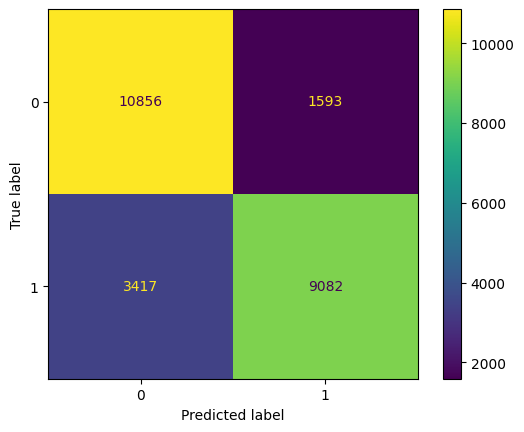

In [42]:
perceptron = Perceptron(early_stopping=True, tol=5, max_iter=1000)
perceptron.fit(X_train, y_train)

y_pred = perceptron.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
f1 = f1_score(y_test, y_pred)
print('f1_score:', f1)

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
labels = [0, 1]
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_display = ConfusionMatrixDisplay(cm).plot()
title = "SEXP_CODE_EStop"
print(title)
Dataset.from_dict({"orig":y_test, "prediction": y_pred}).to_json("exp_sexp_code_EStop_predicitons.json")
plt.savefig('confusion_matrix_'+title+'_1.jpg')

In [47]:
print(classification_report(y_test, y_pred, target_names=["не являются клонами", "являются клонами"]))

                     precision    recall  f1-score   support

не являются клонами       0.98      0.64      0.78     12544
   являются клонами       0.73      0.98      0.84     12404

           accuracy                           0.81     24948
          macro avg       0.85      0.81      0.81     24948
       weighted avg       0.85      0.81      0.81     24948



In [59]:
def get_table(ch_1, ch_2):
    a = 0
    b = 0
    c = 0
    d = 0
    for i in range(len(ch_1)):
        if ch_1[i] == 1 and ch_2[i] == 1:
            a += 1
        elif ch_1[i] == 1 and ch_2[i] == 0:
            b += 1
        elif ch_1[i] == 0 and ch_2[i] == 1:
            c += 1
        elif ch_1[i] == 0 and ch_2[i] == 0:
            d += 1
            
    return [[a,b],[c,d]]
    

In [61]:
from statsmodels.stats.contingency_tables import mcnemar 

def tt(ch_1, ch_2):
	result = mcnemar(get_table(ch_1, ch_2), exact=True)
	print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))
	alpha = 0.05
	if result.pvalue > alpha:
		print('H0 не отвергнута, аугментация не эффективна')
	else:
		print('H0 отвергнута, аугментация эффективна')
	print(f"p-value: {result.pvalue}")

In [51]:
simple_code = load_dataset("json", data_files="Experiments_1\простой_код\простой_код_prediction.json")["train"]
print(simple_code)
simple_code_result = []
for el in simple_code:
    if el["prediction"] == el["orig"]:
        simple_code_result.append(1)
    else:
        simple_code_result.append(0)
print(simple_code_result)

Generating train split: 24948 examples [00:00, 507998.18 examples/s]


Dataset({
    features: ['orig', 'prediction'],
    num_rows: 24948
})
[1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [52]:
sexp_code = load_dataset("json", data_files="s_выражения_prediction.json")["train"]
print(sexp_code)
sexp_code_result = []
for el in sexp_code:
    if el["prediction"] == el["orig"]:
        sexp_code_result.append(1)
    else:
        sexp_code_result.append(0)
print(sexp_code_result)

Generating train split: 24948 examples [00:00, 1086542.72 examples/s]


Dataset({
    features: ['orig', 'prediction'],
    num_rows: 24948
})
[1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0

In [63]:
print(tt(simple_code_result, sexp_code_result))

statistic=3771.000, p-value=0.000
H0 отвергнута, аугментация эффективна
p-value: 0.00041273672335529447
None
